In [32]:
import keras.models
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers

In [33]:
# Download and import visualkeras library
import visualkeras

In [34]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [35]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [36]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Data import

In [37]:
all_data_dir = './training_data_final'
dataset_dir = './SplitData/data'
training_dir = './SplitData/data/training'
validation_dir = './SplitData/data/validation'
test_dir = './SplitData/data/test'

In [38]:
labels = ['Species1', 'Species2', 'Species3', 'Species4', 'Species5', 'Species6', 'Species7', 'Species8']

In [39]:
# Parameters

batch_size = 32

In [40]:
# Images are divided into folders, one for each class.
# If the images are organized in such a way, we can exploit the
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator(rescale=1./255)
valid_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=True,
                                               seed=seed)
valid_gen = train_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=labels, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=batch_size,
                                               shuffle=True,
                                               seed=seed)
test_gen = train_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(96,96),
                                              color_mode='rgb',
                                              classes=labels, # can be set to labels
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              shuffle=False,
                                              seed=seed)

Found 2701 images belonging to 8 classes.
Found 366 images belonging to 8 classes.
Found 475 images belonging to 8 classes.


## Augmentation

Rotation: {'theta': -10.036790492211, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Shift: {'theta': 0, 'tx': 0, 'ty': -28, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Zoom: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 0.9749080237694725, 'zy': 1.0901428612819832, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Flip: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 1, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 



Text(0.5, 1.0, 'Flipped')

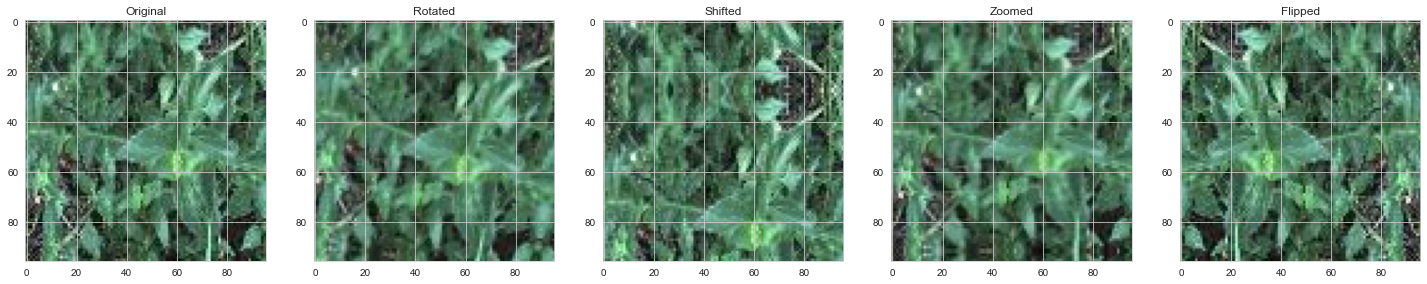

In [41]:
# Create some augmentation examples
# Get sample image
image = next(train_gen)[0][0]

# Create an instance of ImageDataGenerator for each transformation
rot_gen = ImageDataGenerator(rotation_range=40)
shift_gen = ImageDataGenerator(width_shift_range=35)
zoom_gen = ImageDataGenerator(zoom_range=0.1)
flip_gen = ImageDataGenerator(horizontal_flip=True)

# Get random transformations
rot_t = rot_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Rotation:', rot_t, '\n')
shift_t = shift_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Shift:', shift_t, '\n')
zoom_t = zoom_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Zoom:', zoom_t, '\n')
flip_t = flip_gen.get_random_transform(img_shape=(96, 96), seed=seed)
print('Flip:', flip_t, '\n')

# Apply the transformation
gen = ImageDataGenerator(fill_mode='reflect', cval=0.)
rotated = gen.apply_transform(image, rot_t)
shifted = gen.apply_transform(image, shift_t)
zoomed = gen.apply_transform(image, zoom_t)
flipped = gen.apply_transform(image, flip_t)

# Plot original and augmented images
fig, ax = plt.subplots(1, 5, figsize=(25, 45))
ax[0].imshow(np.uint8(image * 255))
ax[0].set_title('Original')
ax[1].imshow(np.uint8(rotated* 255))
ax[1].set_title('Rotated')
ax[2].imshow(np.uint8(shifted* 255))
ax[2].set_title('Shifted')
ax[3].imshow(np.uint8(zoomed* 255))
ax[3].set_title('Zoomed')
ax[4].imshow(np.uint8(flipped* 255))
ax[4].set_title('Flipped')

In [42]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=20,
                                        #height_shift_range=0.1,
                                        #width_shift_range=0.1,
                                        zoom_range=0.6,
                                        #shear_range=0.2,
                                        #horizontal_flip=True,
                                        #vertical_flip=True,
                                        brightness_range=(0.6, 1.4),
                                        fill_mode='reflect',
                                        rescale=1./255) # rescale value is multiplied to the image

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       seed=seed)

Found 2701 images belonging to 8 classes.


## Model

In [43]:
input_shape = (96, 96, 3)
epochs = 200

In [44]:
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)

  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'),
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)

  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [51]:
from keras_tuner import HyperParameters

def build_model(hp: HyperParameters):

    # Build the neural network layer by layer
    model = tfk.models.Sequential()

    model.add(tfk.layers.Conv2D(
        filters=hp.Int('units_1', min_value=32, max_value=128, step=32),
        kernel_size=3,
        input_shape=input_shape,
        padding='same',
        activation='relu')
    )

    if hp.Boolean("pooling_1"):
        model.add(tfk.layers.MaxPooling2D())


    model.add(tfk.layers.Conv2D(
        filters=hp.Int('units_2', min_value=32, max_value=128, step=32),
        kernel_size=5,
        padding='same',
        activation='relu')
    )

    if hp.Boolean("pooling_2"):
        model.add(tfk.layers.MaxPooling2D())


    model.add(tfk.layers.Conv2D(
        filters=hp.Int('units_3', min_value=64, max_value=256, step=32),
        kernel_size=3,
        padding='same',
        activation='relu')
    )
    model.add(tfk.layers.MaxPooling2D())

    model.add(tfk.layers.Flatten())
    for i in range(hp.Int('num_dense_layers', 1, 4)):
        model.add(tfk.layers.Dense(
            units=hp.Int(f"dense_units_{i}", min_value=64, max_value=128, step=32),
            activation=hp.Choice("activation", ["relu", "leaky_relu"]),
            kernel_initializer=tfk.initializers.HeUniform(seed))
        )
        if hp.Boolean(f"dense_dropout_{i}"):
            model.add(tfk.layers.Dropout(hp.Float(f"dense_dropout_{i}_value", 0.2, 0.4, 0.1)))

    model.add(tfk.layers.Dense(8, activation='softmax', name='output', kernel_initializer=tfk.initializers.GlorotUniform(seed)))

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [52]:
# Build model (for data augmentation training)
model = build_model(HyperParameters())
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 32)        25632     
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 147456)            0         
                                                                 
 dense_1 (Dense)             (None, 64)                9437248   
                                                      

In [53]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory="search_results",
    project_name='homework1'
)

## Tuning

In [54]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [55]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
pooling_1 (Boolean)
{'default': False, 'conditions': []}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
pooling_2 (Boolean)
{'default': False, 'conditions': []}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': None}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
dense_units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'leaky_relu'], 'ordered': False}
dense_dropout_0 (Boolean)
{'default': False, 'conditions': []}


In [56]:
tuner.search(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    batch_size=batch_size,
    callbacks=[early_stop]
)

Trial 9 Complete [00h 10m 58s]
val_accuracy: 0.3306010961532593

Best val_accuracy So Far: 0.6475409865379333
Total elapsed time: 01h 24m 48s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
64                |128               |units_1
False             |True              |pooling_1
96                |64                |units_2
True              |True              |pooling_2
160               |128               |units_3
2                 |3                 |num_dense_layers
96                |128               |dense_units_0
leaky_relu        |leaky_relu        |activation
True              |True              |dense_dropout_0
64                |96                |dense_units_1
False             |False             |dense_dropout_1
0.3               |0.3               |dense_dropout_0_value
0.4               |0.2               |dense_dropout_1_value
64                |96                |dense_units_2
True              |False             |dense_dropout_2
9

KeyboardInterrupt: 

In [26]:
tuner.results_summary()

Results summary
Results in search_results/homework1
Showing 10 best trials
Trial summary
Hyperparameters:
units_1: 96
pooling_1: False
units_2: 112
pooling_2: True
units_3: 224
num_dense_layers: 2
dense_units_0: 192
activation: relu
dense_units_1: 128
dense_units_2: 96
Score: 0.6420764923095703
Trial summary
Hyperparameters:
units_1: 96
pooling_1: True
units_2: 48
pooling_2: True
units_3: 192
num_dense_layers: 2
dense_units_0: 128
activation: leaky_relu
dense_units_1: 96
dense_units_2: 128
Score: 0.617486298084259
Trial summary
Hyperparameters:
units_1: 32
pooling_1: True
units_2: 48
pooling_2: False
units_3: 192
num_dense_layers: 2
dense_units_0: 96
activation: relu
dense_units_1: 160
dense_units_2: 64
Score: 0.6120218634605408
Trial summary
Hyperparameters:
units_1: 96
pooling_1: True
units_2: 64
pooling_2: False
units_3: 128
num_dense_layers: 1
dense_units_0: 192
activation: leaky_relu
dense_units_1: 96
dense_units_2: 192
Score: 0.6010928750038147
Trial summary
Hyperparameters:
unit

In [28]:
best_model = tuner.get_best_models(2)[0]

In [29]:
best_model.build(input_shape=input_shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 96)        2688      
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 112)       268912    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 112)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 224)       226016    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 224)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 129024)            0

In [30]:
best_model.save("data_augmentation_experiments/CNN_Aug_Best")

In [770]:
# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_Aug')

# Train the model
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
    batch_size=batch_size
).history

Epoch 1/200


2022-11-15 20:20:26.026814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


85/85 [==============================] - ETA: 0s - loss: 2.0028 - accuracy: 0.1799

2022-11-15 20:20:34.566748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


85/85 [==============================] - 11s 114ms/step - loss: 2.0028 - accuracy: 0.1799 - val_loss: 1.8481 - val_accuracy: 0.2077
Epoch 2/200
85/85 [==============================] - 9s 100ms/step - loss: 1.8356 - accuracy: 0.2655 - val_loss: 1.9945 - val_accuracy: 0.2787
Epoch 3/200
85/85 [==============================] - 8s 93ms/step - loss: 1.7732 - accuracy: 0.2951 - val_loss: 1.9926 - val_accuracy: 0.2022
Epoch 4/200
85/85 [==============================] - 9s 104ms/step - loss: 1.6683 - accuracy: 0.3739 - val_loss: 1.9640 - val_accuracy: 0.2459
Epoch 5/200
85/85 [==============================] - 9s 103ms/step - loss: 1.5898 - accuracy: 0.4013 - val_loss: 2.0128 - val_accuracy: 0.2705
Epoch 6/200
85/85 [==============================] - 9s 103ms/step - loss: 1.5396 - accuracy: 0.4421 - val_loss: 1.6820 - val_accuracy: 0.3934
Epoch 7/200
85/85 [==============================] - 9s 108ms/step - loss: 1.4471 - accuracy: 0.4632 - val_loss: 1.6014 - val_accuracy: 0.4536
Epoch 8/200

In [771]:
# Save best epoch model
model.save("data_augmentation_experiments/CNN_Aug_Best")

In [772]:
# Trained with data augmentation
model_aug = tfk.models.load_model("data_augmentation_experiments/CNN_Aug_Best")
model_aug_test_metrics = model_aug.evaluate(test_gen, return_dict=True)

print()
print("Test metrics with data augmentation")
print(model_aug_test_metrics)


2022-11-15 20:35:56.437902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 37ms/step - loss: 1.1294 - accuracy: 0.7053

Test metrics with data augmentation
{'loss': 1.1294467449188232, 'accuracy': 0.7052631378173828}


In [609]:
# Max reached in test: 0.7

In [189]:
batch = next(train_gen)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 48, 48, 32)        25632     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 12, 12, 64)      

In [210]:
img = tf.io.read_file('{}/training/{}/{}'.format(dataset_dir, "Species8", "00000.jpg"))
img = tf.io.decode_jpeg(img, channels=3)

img = img * 1/255

out = model_aug.predict(tf.expand_dims(img, 0))
out = tf.argmax(out, axis=-1)

out.numpy()

1/1 [==============================] - 0s 24ms/step


array([1])